In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
import numpy as np
from PIL import Image
import time
import functools
import cv2
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import keras.preprocessing.image as kp_image

CONVERT PNG TO JPG

In [ ]:
def convert_png_to_jpg(png_file_path, jpg_file_path, background_color=(255, 255, 255)):
    with Image.open(png_file_path) as img:
      
        if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
            background = Image.new('RGB', img.size, background_color)
            background.paste(img, mask=img.split()[3])
            img = background

        
        img.save(jpg_file_path, quality=95)
png_file_path='/content/drive/MyDrive/nst4image/content_image/2021-08-14.png'
jpg_file_path='/content/drive/MyDrive/nst4image/content_image/2021-08-14.jpg'
convert_png_to_jpg(png_file_path, jpg_file_path)

### **IMAGE PATHS**

In [33]:
#FOR IMAGE STYLING
content_path = '/content/drive/MyDrive/nst4image/content_image/2021-08-14.jpg'
style_path='/content/drive/MyDrive/nst4image/style_image/mona.jpg'

### **MAIN CODE**

In [ ]:
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim / long
    img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)), Image.NEAREST)

   
    img = np.expand_dims(img, axis=0) # type: ignore
    return img

In [35]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [ ]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")

 
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
#VGG19 LAYERS
content_layers = ['block4_conv2']


style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def get_model():
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model
  return models.Model(vgg.input, model_outputs)

In [39]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [ ]:
def gram_matrix(input_tensor):
  
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""

  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)

  return tf.reduce_mean(tf.square(gram_style - gram_target))

In [ ]:
def get_feature_representations(model, content_path, style_path):
 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)

 
  style_outputs = model(style_image)
  content_outputs = model(content_image)


  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

  model_outputs = model(init_image)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  style_score = 0
  content_score = 0
  style_weight=0.001
  content_weight=1
  
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

  style_score *= style_weight
  content_score *= content_weight

 
  loss = style_score + content_score
  return loss, style_score, content_score

In [ ]:
def compute_grads(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
 
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [ ]:
import IPython.display

def run_style_transfer(content_path,
                       style_path,
                       num_iterations=512,
                       content_weight=2,
                       style_weight=0.00001):
 
  model = get_model()
  for layer in model.layers:
    layer.trainable = False

 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

 
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  
  opt = tf.optimizers.Adam(learning_rate=5, epsilon=1e-1) #original lr=5,epi=1e-1

 
  iter_count = 1

  
  best_loss, best_img = float('inf'), None

 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
 
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()

  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means

  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time()

    if loss < best_loss:
      
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()

      
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))
      print('Total loss: {:.4e}, '
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])

  return best_img, best_loss

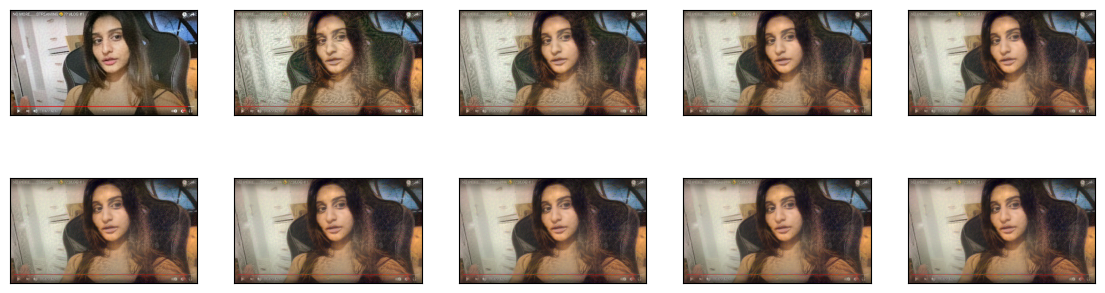

In [47]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=500)

In [48]:
def get_image_dimensions(image_path):
    image = Image.open(image_path)
    width, height = image.size
    image.close()
    return width, height

In [49]:
def resize_image(input_path, output_path, new_size):
    original_image = Image.open(input_path)
    resized_image = original_image.resize(new_size, Image.LANCZOS)
    resized_image.save(output_path)

In [50]:
plt.imsave('/content/drive/MyDrive/nst4image/final_images/ar1.png', np.squeeze(best)) # type: ignore

In [51]:
image_width, image_height = get_image_dimensions(content_path)

stylized_image_path = "/content/drive/MyDrive/nst4image/final_images/ar1.png"
output_image_path = "/content/drive/MyDrive/nst4image/final_images/ar1.png"
new_dimensions = (image_width, image_height)
resize_image(stylized_image_path, output_image_path, new_dimensions)

<Figure size 1000x500 with 0 Axes>

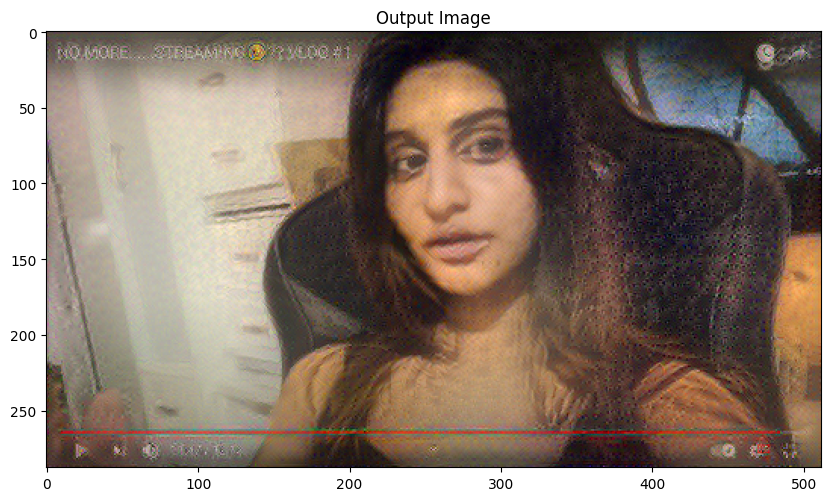

In [52]:
def show_results(best_img,show_large_final=True):
  plt.figure(figsize=(10, 5))
  if show_large_final:
    plt.figure(figsize=(10, 10))
    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()
show_results(best)